# Лабораторная работа №6. Настройка рекуррентной нейросети для исследования сигналов

Пан Анатолий Эдуардович<br>
Группа 932209<br>
Набор данных: https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data

## Загрузка набора данных из Kaggle

In [ ]:
# Install kaggle
!pip install -q kaggle

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change directory
import os
os.chdir("/content/drive/MyDrive/Nauchka")

In [ ]:
# Create a kaggle folder
!mkdir -p ~/.kaggle

# Copy kaggle.json to created folder
!cp kaggle.json ~/.kaggle/

In [ ]:
os.chdir("/content")

In [ ]:
# Permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the required dataset
!kaggle datasets download -d selfishgene/historical-hourly-weather-data

 42% 5.00M/12.0M [00:00<00:00, 46.7MB/s]
100% 12.0M/12.0M [00:00<00:00, 92.3MB/s]


In [ ]:
# Unzip our dataset
from zipfile import ZipFile
from tqdm import tqdm


file_to_extract = "/content/historical-hourly-weather-data.zip"

# Open your .zip file
with ZipFile(file=file_to_extract) as zip_file:

    # Loop over each file and extract them
    for file in tqdm(iterable=zip_file.namelist(), total=len(zip_file.namelist())):
        zip_file.extract(member=file)

100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


## Установим необходимые библиотеки

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Подготовка данных

Откроем необходимые данные

In [89]:
df = pd.read_csv("/content/temperature.csv")
df.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
1,2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,...,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.4,304.4,303.5
2,2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,...,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.4,304.4,303.5
3,2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,...,285.756824,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.4,304.4,303.5
4,2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,...,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.4,304.4,303.5


Посмотрим на список имеющихся городов

In [90]:
df.columns

Index(['datetime', 'Vancouver', 'Portland', 'San Francisco', 'Seattle',
       'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque',
       'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City',
       'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis',
       'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami',
       'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal',
       'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa',
       'Nahariyya', 'Jerusalem'],
      dtype='object')

Для этой лабораторной работы я выберу город San Francisco. Удалим все остальные города

In [91]:
df = df[["datetime", "San Francisco"]]
df.head()

,datetime,San Francisco
0,2012-10-01 12:00:00,NaN
1,2012-10-01 13:00:00,289.480000
2,2012-10-01 14:00:00,289.474993
3,2012-10-01 15:00:00,289.460618
4,2012-10-01 16:00:00,289.446243


Размер датасета

In [92]:
df.shape

(45253, 2)

Проверим данные на пустые значения. Если таковые будут, то удалим их

In [93]:
df.isna().sum()

datetime           0
San Francisco    793
dtype: int64

In [94]:
df = df.dropna()

Выполним масштабирование данных

In [95]:
data = df["San Francisco"].values
scaler = MinMaxScaler(feature_range=(0, 1))
data = data.reshape(-1, 1)
data = scaler.fit_transform(data).flatten()

Выполните сглаживание данных для уменьшения отдельных значений содержащие
статистические аномалии: для уменьшения влияния отдельных необычно больших или
малых значений на результат вычисления

Выполните обработку скользящим окном размера 20

In [96]:
def get_XY(data, window):
    Y_index = np.arange(window, len(data), window)
    Y = data[Y_index]
    rows_x = len(Y)
    X = data[range(window * rows_x)]
    X = np.reshape(X, (rows_x, window, 1))
    return X, Y

In [97]:
window = 20
X, y = get_XY(data, window)

Разделим наборы данных на выборку: обучающую и тестовую

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## 1. Простая рекуррентная нейронная сеть

Рекуррентная нейронная сеть (RNN) с одним слоем SimpleRNN и одним полносвязанным слоем Dense

- `hidden_units` - количество нейронов в слое SimpleRNN;
- `dense_units` - количество нейронов в полносвязанном слое Dense;
- `input_shape` - форма входных данных. Она определяется как `(window, 1)`, что означает, что входные данные представляют временные ряды с окном размера `window`, и каждая точка данных имеет одну фичу;
- `activation` - список из двух активационных функций. Первая активационная функция применяется к SimpleRNN слою, а вторая - к Dense слою;

In [100]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units,
                        input_shape=input_shape,
                        activation=activation[0],
                        return_sequences=False))
    model.add(Dense(units=dense_units, activation=activation[1]))

    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])

    model.summary()
    return model

In [101]:
rnn_model = create_RNN(hidden_units=32,
                   dense_units=1,
                   input_shape=(window, 1),
                   activation=['relu', 'linear']
                   )

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1121 (4.38 KB)
Trainable params: 1121 (4.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Запустим обучение

In [102]:
history = rnn_model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=32,
                    verbose=1,
                    validation_split=0.2
                    )

Epoch 1/20
45/45 [==============================] - 2s 12ms/step - loss: 0.0178 - mean_absolute_error: 0.1008 - mean_squared_error: 0.0178 - val_loss: 0.0066 - val_mean_absolute_error: 0.0661 - val_mean_squared_error: 0.0066
Epoch 2/20
45/45 [==============================] - 0s 6ms/step - loss: 0.0062 - mean_absolute_error: 0.0638 - mean_squared_error: 0.0062 - val_loss: 0.0057 - val_mean_absolute_error: 0.0609 - val_mean_squared_error: 0.0057
Epoch 3/20
45/45 [==============================] - 0s 8ms/step - loss: 0.0054 - mean_absolute_error: 0.0592 - mean_squared_error: 0.0054 - val_loss: 0.0049 - val_mean_absolute_error: 0.0570 - val_mean_squared_error: 0.0049
Epoch 4/20
45/45 [==============================] - 0s 11ms/step - loss: 0.0045 - mean_absolute_error: 0.0538 - mean_squared_error: 0.0045 - val_loss: 0.0041 - val_mean_absolute_error: 0.0514 - val_mean_squared_error: 0.0041
Epoch 5/20
45/45 [==============================] - 0s 11ms/step - loss: 0.0038 - mean_absolute_error:

Визуализируем результаты

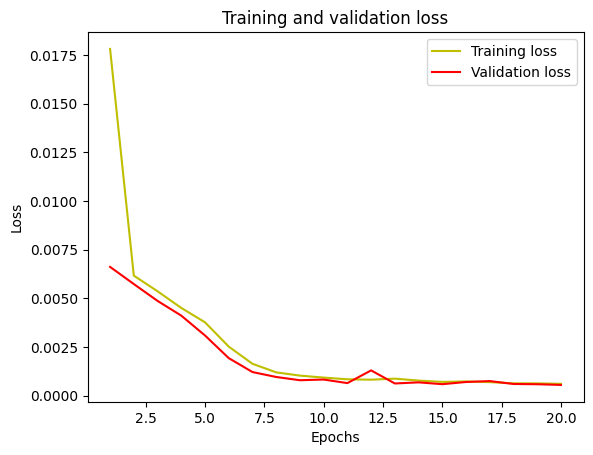

In [103]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Посмотрим на значения отклонений и ошибок

In [104]:
def print_error(trainY, testY, train_predict, test_predict):
    # Error of predictions (train)
    train_mae = (mean_absolute_error(trainY, train_predict))
    train_mse = (mean_squared_error(trainY, train_predict))

    # Error of predictions (test)
    test_mae = (mean_absolute_error(testY, test_predict))
    test_mse = (mean_squared_error(testY, test_predict))

    return train_mae, train_mse, test_mae, test_mse

In [105]:
# make predictions
rnn_train_predict = rnn_model.predict(X_train)
rnn_test_predict = rnn_model.predict(X_test)
train_mae, train_mse, test_mae, test_mse = print_error(y_train, y_test, rnn_train_predict, rnn_test_predict)

# Print RMSE
print('train MAE: %.10f' % (train_mae))
print('train MSE: %.10f' % (train_mse))
print('test MAE: %.10f' % (test_mae))
print('test MSE: %.10f' % (test_mse))

14/14 [==============================] - 0s 2ms/step
train MAE: 0.0180545893
train MSE: 0.0005917612
test MAE: 0.0173467651
test MSE: 0.0005254364


In [106]:
def plot_result(testY, test_predict, model):
    actual = testY
    predictions = test_predict
    rows = len(actual)
    plt.figure(figsize=(15, 6),dpi=100)
    plt.plot(range(rows), actual, linewidth=0.9)
    plt.plot(range(rows), predictions, linewidth=0.7)
    plt.legend(['Реальная температура', 'Предсказание'])
    plt.xlabel('Номер наблюдения')
    plt.ylabel('Отмасштабированная температура')
    plt.title(f'Реальная и предсказанная температура ({model})')

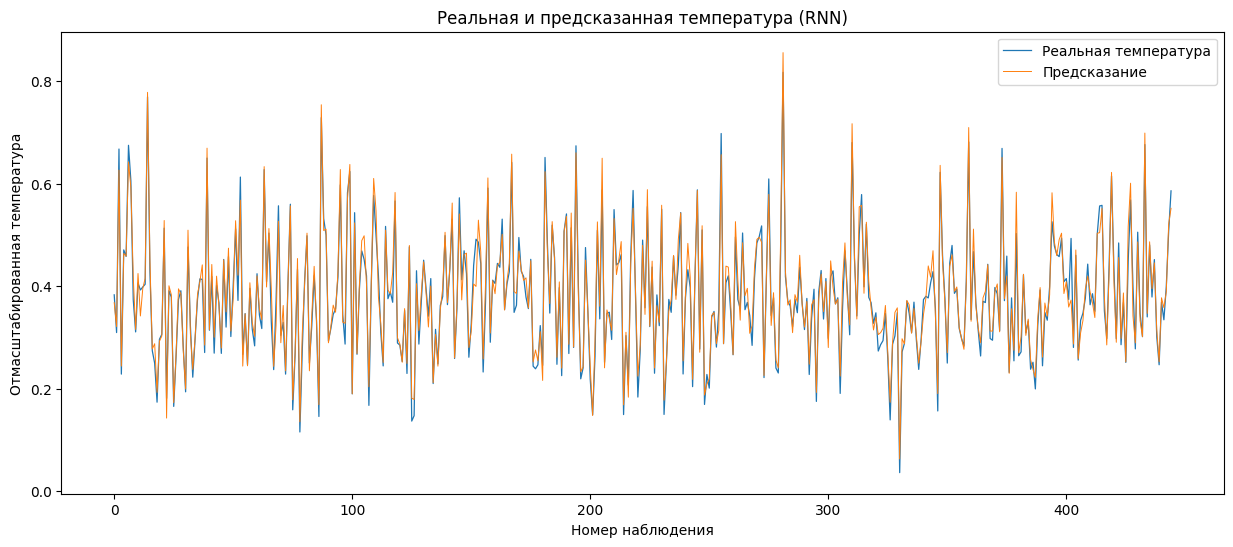

In [107]:
plot_result(y_test, rnn_test_predict, "RNN")

## 2. LSTM

In [108]:
def create_LSTM(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units,
                   activation=activation[0],
                   input_shape=input_shape))
    model.add(Dense(units=dense_units, activation=activation[1]))

    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    model.summary()
    return model

In [109]:
lstm_model = create_LSTM(hidden_units=32,
                         dense_units=1,
                         input_shape=(window, 1),
                         activation=['relu', 'linear']
                         )

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 32)                4352      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Запустим обучение

In [110]:
history = lstm_model.fit(X_train,
                         y_train,
                         epochs=20,
                         batch_size=32,
                         verbose=1,
                         validation_split=0.2
                         )

Epoch 1/20
45/45 [==============================] - 4s 24ms/step - loss: 0.1016 - mean_absolute_error: 0.2735 - mean_squared_error: 0.1016 - val_loss: 0.0084 - val_mean_absolute_error: 0.0773 - val_mean_squared_error: 0.0084
Epoch 2/20
45/45 [==============================] - 2s 40ms/step - loss: 0.0083 - mean_absolute_error: 0.0739 - mean_squared_error: 0.0083 - val_loss: 0.0074 - val_mean_absolute_error: 0.0679 - val_mean_squared_error: 0.0074
Epoch 3/20
45/45 [==============================] - 1s 33ms/step - loss: 0.0068 - mean_absolute_error: 0.0676 - mean_squared_error: 0.0068 - val_loss: 0.0064 - val_mean_absolute_error: 0.0666 - val_mean_squared_error: 0.0064
Epoch 4/20
45/45 [==============================] - 2s 37ms/step - loss: 0.0061 - mean_absolute_error: 0.0636 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_absolute_error: 0.0641 - val_mean_squared_error: 0.0059
Epoch 5/20
45/45 [==============================] - 1s 15ms/step - loss: 0.0053 - mean_absolute_erro

Визуализируем результаты

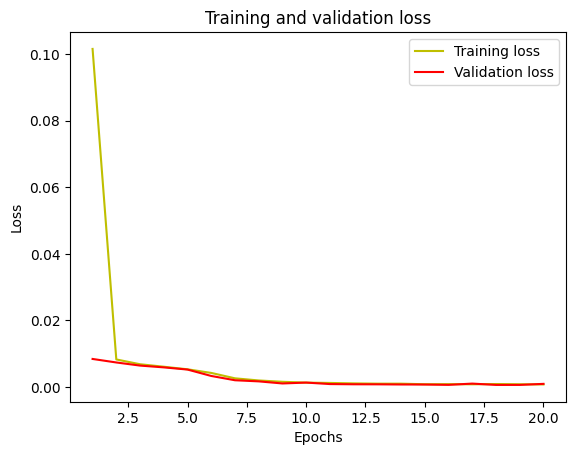

In [111]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Посмотрим на значения отклонений и ошибок

In [112]:
# make predictions
lstm_train_predict = lstm_model.predict(X_train)
lstm_test_predict = lstm_model.predict(X_test)
train_mae, train_mse, test_mae, test_mse = print_error(y_train, y_test, lstm_train_predict, lstm_test_predict)

# Print RMSE
print('train MAE: %.10f' % (train_mae))
print('train MSE: %.10f' % (train_mse))
print('test MAE: %.10f' % (test_mae))
print('test MSE: %.10f' % (test_mse))

14/14 [==============================] - 0s 4ms/step
train MAE: 0.0237130046
train MSE: 0.0009374382
test MAE: 0.0217846966
test MSE: 0.0008413669


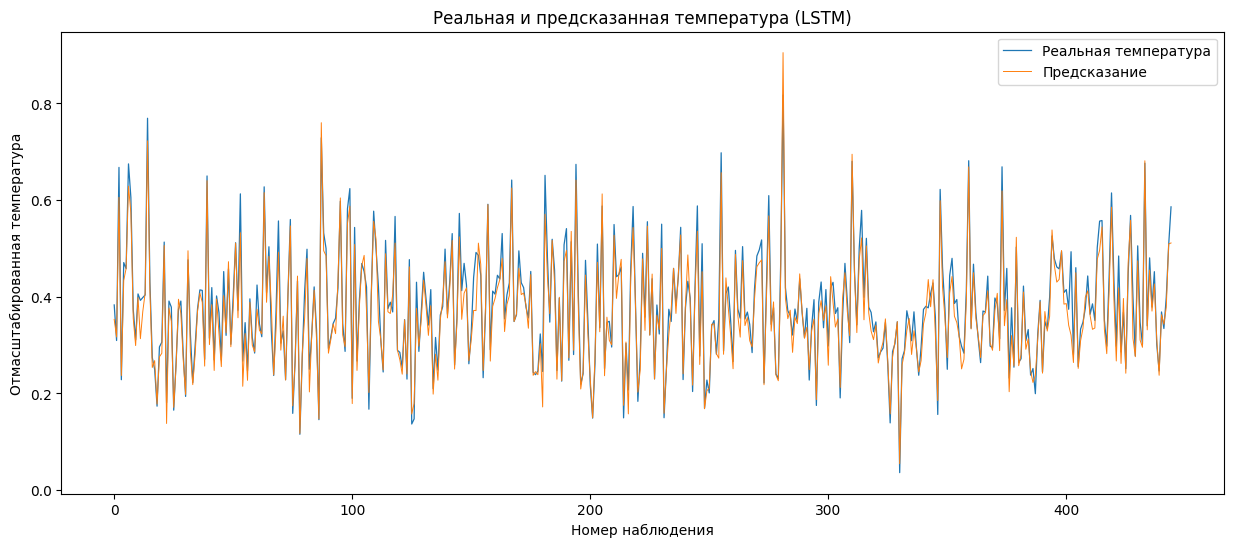

In [113]:
plot_result(y_test, lstm_test_predict, "LSTM")

## 3. Stacked LSTM

In [114]:
def create_stacked_LSTM(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units,
                   activation=activation[0],
                   return_sequences=True,
                   input_shape=input_shape))
    model.add(LSTM(hidden_units,
                   activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))

    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    model.summary()
    return model

In [115]:
stacked_lstm_model = create_stacked_LSTM(hidden_units=32,
                                         dense_units=1,
                                         input_shape=(window, 1),
                                         activation=['relu', 'linear']
                                         )

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 20, 32)            4352      
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 12705 (49.63 KB)
Trainable params: 12705 (49.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Запустим обучение

In [116]:
history = stacked_lstm_model.fit(X_train,
                                 y_train,
                                 epochs=20,
                                 batch_size=32,
                                 verbose=1,
                                 validation_split=0.2
                                 )

Epoch 1/20
45/45 [==============================] - 4s 29ms/step - loss: 0.0481 - mean_absolute_error: 0.1682 - mean_squared_error: 0.0481 - val_loss: 0.0104 - val_mean_absolute_error: 0.0824 - val_mean_squared_error: 0.0104
Epoch 2/20
45/45 [==============================] - 1s 20ms/step - loss: 0.0106 - mean_absolute_error: 0.0829 - mean_squared_error: 0.0106 - val_loss: 0.0101 - val_mean_absolute_error: 0.0839 - val_mean_squared_error: 0.0101
Epoch 3/20
45/45 [==============================] - 1s 20ms/step - loss: 0.0094 - mean_absolute_error: 0.0791 - mean_squared_error: 0.0094 - val_loss: 0.0089 - val_mean_absolute_error: 0.0775 - val_mean_squared_error: 0.0089
Epoch 4/20
45/45 [==============================] - 1s 22ms/step - loss: 0.0084 - mean_absolute_error: 0.0752 - mean_squared_error: 0.0084 - val_loss: 0.0076 - val_mean_absolute_error: 0.0722 - val_mean_squared_error: 0.0076
Epoch 5/20
45/45 [==============================] - 1s 32ms/step - loss: 0.0066 - mean_absolute_erro

Визуализируем результаты

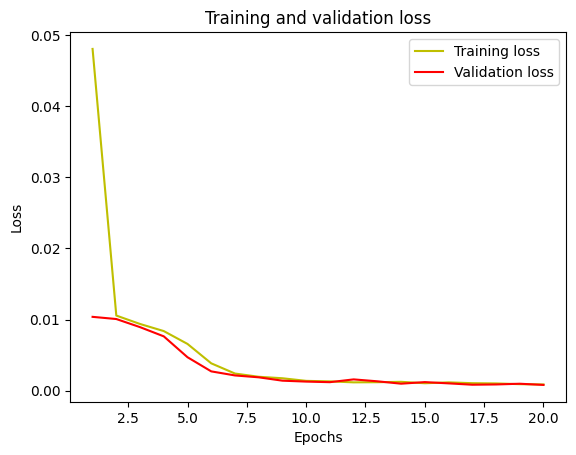

In [117]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Посмотрим на значения отклонений и ошибок

In [118]:
# make predictions
stacked_lstm_train_predict = stacked_lstm_model.predict(X_train)
stacked_lstm_test_predict = stacked_lstm_model.predict(X_test)
train_mae, train_mse, test_mae, test_mse = print_error(y_train, y_test, stacked_lstm_train_predict, stacked_lstm_test_predict)

# Print RMSE
print('train MAE: %.10f' % (train_mae))
print('train MSE: %.10f' % (train_mse))
print('test MAE: %.10f' % (test_mae))
print('test MSE: %.10f' % (test_mse))

14/14 [==============================] - 0s 6ms/step
train MAE: 0.0215693677
train MSE: 0.0008332762
test MAE: 0.0205110785
test MSE: 0.0007366619


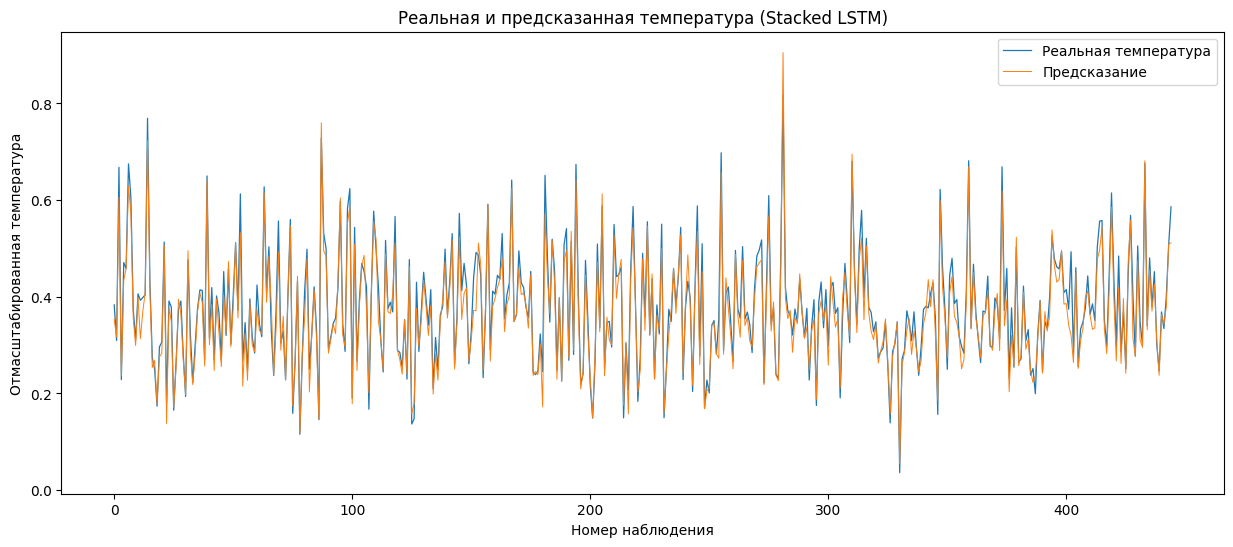

In [119]:
plot_result(y_test, lstm_test_predict, "Stacked LSTM")

## Выведем все метрики

In [120]:
rnn = print_error(y_train, y_test, rnn_train_predict, rnn_test_predict)
lstm = print_error(y_train, y_test, lstm_train_predict, lstm_test_predict)
stacked_lstm = print_error(y_train, y_test, stacked_lstm_train_predict, stacked_lstm_test_predict)

In [121]:
data = [rnn, lstm, stacked_lstm]
columns = ["train MAE", "train MSE", "test MAE", "test MSE"]
index = ["rnn", "lstm", "stacked_lstm"]

df = pd.DataFrame(data, columns=columns, index=index)
df

,train MAE,train MSE,test MAE,test MSE
rnn,0.018055,0.000592,0.017347,0.000525
lstm,0.023713,0.000937,0.021785,0.000841
stacked_lstm,0.021569,0.000833,0.020511,0.000737
